# **Loan Default Prediction Challenge**

**Problem description**

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

A good loan means the borrower paid it back in time, and a bad loan means the borrower defaulted because they have not made their scheduled payments for a predetermined amount of time.

In [642]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [643]:
!pip install category_encoders
!pip install pandas-profiling xgboost gradio


Let's first import some libraries.

In [644]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import joblib
from datetime import datetime, date
import calendar
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

Let's have a look at the data provided in our datasets:
First we load and store them in appropriately named variables.
**demo** contains demographic data of people taking out loans as follows:

a) Demographic data (traindemographics.csv)

*   customerid (Primary key used to merge to other data)
*   birthdate (date of birth of the customer)
*   bank_account_type (type of primary bank account)
*   longitude_gps
*   latitude_gps
*   bank_name_clients (name of the bank)
*   bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
*   employment_status_clients (type of employment that customer has)
*   level_of_education_clients (highest level of education)

In [645]:
demo = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/traindemographics.csv')
demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


**perf** contains data of the repeat loan that the customer has taken for which we need to predict the performance of. This is the current loan data, but we are predicting whether this loan would default given all previous loans and demographics of the customer. It has the following descriptions:

b) Performance data (trainperf.csv) :

*   customerid (Primary key used to merge to other data)
*   systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
*   loannumber (The number of the loan that you have to predict)
*   approveddate (Date that loan was approved)
*   creationdate (Date that loan application was created)
*   loanamount (Loan value taken)
*   totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
*   termdays (Term of loan)
*   referredby (customerId of the customer that referred this person - is missing, then not referred)
*   good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict


In [646]:
perf = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/trainperf.csv')
perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


**prev** has all previous loans that the customer had prior to the loan above (perf) that we want to predict the performance of. Each loan has a different systemloanid, but the same customerid for each customer.

c) Previous loans data (trainprevloans.csv) :

*   customerid (Primary key used to merge to other data)
*   systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
*   loannumber (The number of the loan that you have to predict)
*   approveddate (Date that loan was approved)
*   creationdate (Date that loan application was created)
*   loanamount (Loan value taken)
*   totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
*   termdays (Term of loan)
*   closeddate (Date that the loan was settled)
*   referredby (customerId of the customer that referred this person - is missing, then not referred)
*   firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
*   firstrepaiddate (Actual date that he/she paid the first payment as defined above)



I think its important to note that the columns in perf and prev are the same in name save for **closed date, firstduedate** and **firstrepaiddate** in prev, and the **good_bad_flag** in perf.

In [647]:
prev = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/trainprevloans.csv')
prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


# **Preliminary understanding of the datasets' shapes.**

In [648]:
demo.dtypes

customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

In [649]:
demo.shape

(4346, 9)

In [650]:
perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

In [651]:
perf.shape

(4368, 10)

In [652]:
prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

In [653]:
prev.shape

(18183, 12)

Some data cleaning.

In [654]:
demo.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64

In [655]:
demo_dup = demo.duplicated().any()
demo_dup

True

In [656]:
dup_count = demo.duplicated().sum()
dup_count

12

Not dropping data because this is being posted to Zindi

In [657]:
# demo = demo.drop_duplicates()

In [658]:
demo.shape

(4346, 9)

In [659]:
demo = demo.drop(columns=['bank_branch_clients'])

In [660]:
demo.shape

(4346, 8)

In [661]:
demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,Permanent,NaN


In [662]:
dup_count1 = perf.duplicated().sum()
dup_count1

0

In [663]:
perf.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [664]:
perf = perf.drop(columns=['referredby'])

In [665]:
perf.shape

(4368, 9)

In [666]:
dup_count2 = prev.duplicated().sum()
dup_count2

0

In [667]:
prev.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [668]:
prev = prev.drop(columns=['referredby'])

In [669]:
prev.shape

(18183, 11)

As **'customerid'** is the primary key, I tried to ensure there were similar values in all the datasets.

In [670]:
demo['customerid'].isin(perf['customerid']).value_counts()

customerid
True     3277
False    1069
Name: count, dtype: int64

In [671]:
prev['customerid'].isin(perf['customerid']).value_counts()

customerid
True    18183
Name: count, dtype: int64

In [672]:
demo['customerid'].isin(prev['customerid']).value_counts()

customerid
True     3272
False    1074
Name: count, dtype: int64

From this information we can conclude that there are shared values in the customerid columns of demo, prev and perf datasets.

In [673]:
demo.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients'],
      dtype='object')

In [674]:
perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag'],
      dtype='object')

In [675]:
prev.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [676]:
prev['systemloanid'].isin(perf['systemloanid']).value_counts()

systemloanid
False    18183
Name: count, dtype: int64

In [677]:
prev['approveddate'].isin(perf['approveddate']).value_counts()

approveddate
False    18182
True         1
Name: count, dtype: int64

In [678]:
prev['loannumber'].isin(perf['loannumber']).value_counts()

loannumber
True     13836
False     4347
Name: count, dtype: int64

While perf and prev have intersecting data in some columns, it is not enough to justify merging all of them. For this reason, we are going to rename the columns in one dataset to separate the information.

In [679]:
perf.columns = ['customerid','perfsystemloanid','perf_loannumber','perf_approveddate','perf_creationdate',
                'perf_loanamount','perf_totaldue','perf_termdays','good_bad_flag']

In [680]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         4368 non-null   object 
 1   perfsystemloanid   4368 non-null   int64  
 2   perf_loannumber    4368 non-null   int64  
 3   perf_approveddate  4368 non-null   object 
 4   perf_creationdate  4368 non-null   object 
 5   perf_loanamount    4368 non-null   float64
 6   perf_totaldue      4368 non-null   float64
 7   perf_termdays      4368 non-null   int64  
 8   good_bad_flag      4368 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 307.2+ KB


In [681]:
loandata = pd.merge(perf, prev, on='customerid', how = 'left')
loandata

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301682320.0,2.0,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30.0,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301883808.0,9.0,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30.0,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301831714.0,8.0,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30.0,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301923941.0,10.0,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30.0,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301954468.0,11.0,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30.0,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18187,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301759763.0,1.0,2016-11-15 20:35:26.000000,2016-11-15 19:35:10.000000,10000.0,13000.0,30.0,2016-12-06 13:18:11.000000,2016-12-15 00:00:00.000000,2016-12-06 13:03:00.000000
18188,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301815698.0,4.0,2017-02-12 23:18:28.000000,2017-02-12 22:18:22.000000,20000.0,23800.0,30.0,2017-03-11 00:44:47.000000,2017-03-14 00:00:00.000000,2017-03-11 00:29:36.000000
18189,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301866256.0,5.0,2017-04-12 18:54:51.000000,2017-04-12 17:54:39.000000,20000.0,23800.0,30.0,2017-05-10 09:13:03.000000,2017-05-12 00:00:00.000000,2017-05-10 08:57:53.000000
18190,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301772787.0,2.0,2016-12-12 23:54:06.000000,2016-12-12 22:53:56.000000,10000.0,13000.0,30.0,2017-01-11 00:02:13.000000,2017-01-11 00:00:00.000000,2017-01-10 23:47:04.000000


In [682]:
loan_data = pd.merge(loandata, demo, on='customerid', how = 'left')
loan_data

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,...,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301682320.0,...,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent,Post-Graduate
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301883808.0,...,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent,Post-Graduate
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301831714.0,...,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent,Post-Graduate
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301923941.0,...,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent,Post-Graduate
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301954468.0,...,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent,Post-Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18207,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301759763.0,...,2016-12-06 13:18:11.000000,2016-12-15 00:00:00.000000,2016-12-06 13:03:00.000000,1988-08-16 00:00:00.000000,Savings,3.725655,6.474430,GT Bank,NaN,NaN
18208,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301815698.0,...,2017-03-11 00:44:47.000000,2017-03-14 00:00:00.000000,2017-03-11 00:29:36.000000,1988-08-16 00:00:00.000000,Savings,3.725655,6.474430,GT Bank,NaN,NaN
18209,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301866256.0,...,2017-05-10 09:13:03.000000,2017-05-12 00:00:00.000000,2017-05-10 08:57:53.000000,1988-08-16 00:00:00.000000,Savings,3.725655,6.474430,GT Bank,NaN,NaN
18210,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,Bad,301772787.0,...,2017-01-11 00:02:13.000000,2017-01-11 00:00:00.000000,2017-01-10 23:47:04.000000,1988-08-16 00:00:00.000000,Savings,3.725655,6.474430,GT Bank,NaN,NaN


In [683]:
loan_data.shape

(18212, 26)

In [684]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18212 entries, 0 to 18211
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  18212 non-null  object 
 1   perfsystemloanid            18212 non-null  int64  
 2   perf_loannumber             18212 non-null  int64  
 3   perf_approveddate           18212 non-null  object 
 4   perf_creationdate           18212 non-null  object 
 5   perf_loanamount             18212 non-null  float64
 6   perf_totaldue               18212 non-null  float64
 7   perf_termdays               18212 non-null  int64  
 8   good_bad_flag               18212 non-null  object 
 9   systemloanid                18203 non-null  float64
 10  loannumber                  18203 non-null  float64
 11  approveddate                18203 non-null  object 
 12  creationdate                18203 non-null  object 
 13  loanamount                  182

**'level_of_education_clients'** has too many null values to justify working with it further to train the model.



In [685]:
loan_data = loan_data.drop(columns=['level_of_education_clients'])

In [686]:
loan_data.shape

(18212, 25)

In [687]:
loan_data.head(15)

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,...,termdays,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301682320.0,...,30.0,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301883808.0,...,30.0,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301831714.0,...,30.0,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301923941.0,...,30.0,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301954468.0,...,30.0,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
5,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301777989.0,...,30.0,2017-02-28 13:20:29.000000,2017-01-20 00:00:00.000000,2017-02-28 13:05:11.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
6,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301739329.0,...,30.0,2016-11-07 08:29:43.000000,2016-11-07 00:00:00.000000,2016-11-07 08:14:34.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
7,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301828139.0,...,30.0,2017-03-01 18:25:25.000000,2017-03-30 00:00:00.000000,2017-03-01 18:10:14.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
8,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301675247.0,...,30.0,2016-08-15 08:49:18.000000,2016-09-08 00:00:00.000000,2016-08-15 08:34:14.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
9,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301705521.0,...,30.0,2016-10-04 18:02:58.000000,2016-10-05 00:00:00.000000,2016-10-04 17:47:49.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent


In [688]:
# Identify outliers
outliers = loan_data.describe().loc[['min', 'max']].T
print(outliers)

                           min           max
perfsystemloanid  3.019585e+08  3.020040e+08
perf_loannumber   2.000000e+00  2.700000e+01
perf_loanamount   1.000000e+04  6.000000e+04
perf_totaldue     1.000000e+04  6.810000e+04
perf_termdays     1.500000e+01  9.000000e+01
systemloanid      3.016001e+08  3.020003e+08
loannumber        1.000000e+00  2.600000e+01
loanamount        3.000000e+03  6.000000e+04
totaldue          3.450000e+03  6.810000e+04
termdays          1.500000e+01  9.000000e+01
longitude_gps    -1.182470e+02  1.512093e+02
latitude_gps     -3.386882e+01  7.122807e+01


In [689]:
# Mean imputation for missing column data
loan_data['systemloanid'] = loan_data['systemloanid'].fillna(loan_data['systemloanid'].mean())
loan_data['loannumber'] = loan_data['loannumber'].fillna(loan_data['loannumber'].mean())
#loan_data['approveddate'] = loan_data['approveddate'].fillna(loan_data['approveddate'].mean())
#loan_data['creationdate'] = loan_data['creationdate'].fillna(loan_data['creationdate'].mean())
loan_data['loanamount'] = loan_data['loanamount'].fillna(loan_data['loanamount'].mean())
loan_data['totaldue'] = loan_data['totaldue'].fillna(loan_data['totaldue'].mean())
loan_data['termdays'] = loan_data['termdays'].fillna(loan_data['termdays'].mean())
#loan_data['closeddate'] = loan_data['closeddate'].fillna(loan_data['closeddate'].mean())
#loan_data['firstduedate'] = loan_data['firstduedate'].fillna(loan_data['firstduedate'].mean())
#loan_data['firstrepaiddate'] = loan_data['firstrepaiddate'].fillna(loan_data['firstrepaiddate'].mean())
#loan_data['birthdate'] = loan_data['birthdate'].fillna(loan_data['birthdate'].mean())
#loan_data['bank_account_type'] = loan_data['bank_account_type'].fillna(loan_data['bank_account_type'].mean())
loan_data['longitude_gps'] = loan_data['longitude_gps'].fillna(loan_data['longitude_gps'].mean())
loan_data['latitude_gps'] = loan_data['latitude_gps'].fillna(loan_data['latitude_gps'].mean())
#loan_data['bank_name_clients'] = loan_data['bank_name_clients'].fillna(loan_data['bank_name_clients'].mean())
#loan_data['employment_status_clients'] = loan_data['employment_status_clients'].fillna(loan_data['employment_status_clients'].mean())

In [690]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18212 entries, 0 to 18211
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 18212 non-null  object 
 1   perfsystemloanid           18212 non-null  int64  
 2   perf_loannumber            18212 non-null  int64  
 3   perf_approveddate          18212 non-null  object 
 4   perf_creationdate          18212 non-null  object 
 5   perf_loanamount            18212 non-null  float64
 6   perf_totaldue              18212 non-null  float64
 7   perf_termdays              18212 non-null  int64  
 8   good_bad_flag              18212 non-null  object 
 9   systemloanid               18212 non-null  float64
 10  loannumber                 18212 non-null  float64
 11  approveddate               18203 non-null  object 
 12  creationdate               18203 non-null  object 
 13  loanamount                 18212 non-null  flo

Let's take note of the numerical and non-numerical columns to decide what approach to take next:

In [691]:
loan_data.columns

Index(['customerid', 'perfsystemloanid', 'perf_loannumber',
       'perf_approveddate', 'perf_creationdate', 'perf_loanamount',
       'perf_totaldue', 'perf_termdays', 'good_bad_flag', 'systemloanid',
       'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue',
       'termdays', 'closeddate', 'firstduedate', 'firstrepaiddate',
       'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients'],
      dtype='object')

In [692]:
categorical = [var for var in loan_data.columns if loan_data[var].dtype == 'O']
print('There are {} categorical variables \n'.format(len(categorical)))
print('They are: ', categorical)

There are 13 categorical variables 

They are:  ['customerid', 'perf_approveddate', 'perf_creationdate', 'good_bad_flag', 'approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate', 'birthdate', 'bank_account_type', 'bank_name_clients', 'employment_status_clients']


In [693]:
numerical = [var for var in loan_data.columns if loan_data[var].dtype != 'O']
print('There are {} numerical variables \n'.format(len(numerical)))
print('They are: ', numerical)

There are 12 numerical variables 

They are:  ['perfsystemloanid', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'longitude_gps', 'latitude_gps']


In [694]:
loan_data[numerical].head()

,perfsystemloanid,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,systemloanid,loannumber,loanamount,totaldue,termdays,longitude_gps,latitude_gps
0,301994762,12,30000.0,34500.0,30,301682320.0,2.0,10000.0,13000.0,30.0,3.43201,6.433055
1,301994762,12,30000.0,34500.0,30,301883808.0,9.0,10000.0,13000.0,30.0,3.43201,6.433055
2,301994762,12,30000.0,34500.0,30,301831714.0,8.0,20000.0,23800.0,30.0,3.43201,6.433055
3,301994762,12,30000.0,34500.0,30,301923941.0,10.0,20000.0,24500.0,30.0,3.43201,6.433055
4,301994762,12,30000.0,34500.0,30,301954468.0,11.0,20000.0,24500.0,30.0,3.43201,6.433055


In [695]:
loan_data[categorical].head()

,customerid,perf_approveddate,perf_creationdate,good_bad_flag,approveddate,creationdate,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,Permanent
1,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,Permanent
2,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,Permanent
3,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,Permanent
4,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,Permanent


# Dealing with categorical data.

We have to understand the categorical data we are working with, and look at its relationships with the data before we encode it.

In [696]:
loan_data['birthdate'] = pd.to_datetime(loan_data['birthdate'])

In [697]:
today = date.today()

In [698]:
today

datetime.date(2024, 6, 8)

In [699]:
loan_data['age'] = round(((datetime.now() - loan_data['birthdate'])/np.timedelta64(1, 'Y')),0)

In [700]:
loan_data.head()

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,...,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301682320.0,...,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15,Other,3.43201,6.433055,Diamond Bank,Permanent,52.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301883808.0,...,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15,Other,3.43201,6.433055,Diamond Bank,Permanent,52.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301831714.0,...,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15,Other,3.43201,6.433055,Diamond Bank,Permanent,52.0
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301923941.0,...,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15,Other,3.43201,6.433055,Diamond Bank,Permanent,52.0
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301954468.0,...,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15,Other,3.43201,6.433055,Diamond Bank,Permanent,52.0


In [701]:
age_pred = loan_data[['age','good_bad_flag']]
age_pred.head()

,age,good_bad_flag
0,52.0,Good
1,52.0,Good
2,52.0,Good
3,52.0,Good
4,52.0,Good


<Axes: xlabel='good_bad_flag', ylabel='age'>

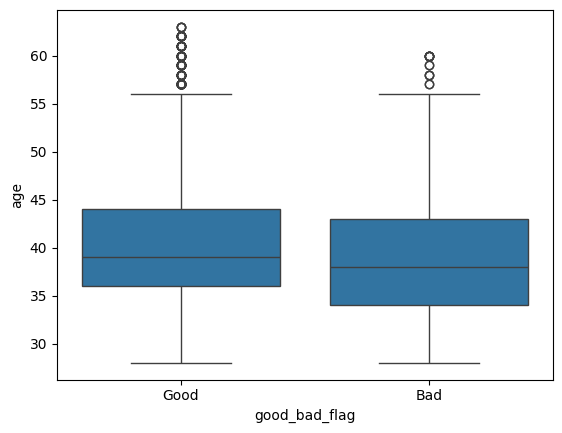

In [702]:
sns.boxplot(x ="good_bad_flag",y="age" ,data = loan_data)

In [703]:
loan_data['bank_account_type'].value_counts()

bank_account_type
Savings    8316
Other      5228
Current     154
Name: count, dtype: int64

In [704]:
loan_data['bank_name_clients'].value_counts()

bank_name_clients
GT Bank               5036
First Bank            1932
Access Bank           1270
UBA                   1127
Diamond Bank           984
Zenith Bank            948
Stanbic IBTC           489
EcoBank                450
FCMB                   420
Skye Bank              272
Fidelity Bank          267
Sterling Bank          112
Wema Bank               89
Heritage Bank           87
Keystone Bank           83
Union Bank              74
Standard Chartered      44
Unity Bank              14
Name: count, dtype: int64

From the earlier data we know that 'employment_status_clients' has several N/A values so let's work on that.

In [705]:
loan_data['employment_status_clients'].unique()

array(['Permanent', nan, 'Unemployed', 'Self-Employed', 'Student',
       'Retired', 'Contract'], dtype=object)

In [706]:
loan_data['employment_status_clients'].fillna("Employment_unknown", inplace=True)

In [707]:
loan_data[categorical].head()

,customerid,perf_approveddate,perf_creationdate,good_bad_flag,approveddate,creationdate,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15,Other,Diamond Bank,Permanent
1,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15,Other,Diamond Bank,Permanent
2,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15,Other,Diamond Bank,Permanent
3,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15,Other,Diamond Bank,Permanent
4,8a2a81a74ce8c05d014cfb32a0da1049,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,Good,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15,Other,Diamond Bank,Permanent


Here, we are working with information I feel may be relevant to creating the model with regards to time.

1.   'creationdate' - 'closeddate', which shall give us the time from when the loan application was created, to when it was settled.
1.   'approveddate' - 'closeddate', which shall give us the time from when the loan was approved, to when it was settled.

Currently, I am considering checking between creation and approved date but I don't think there is any correlation in the data. We shall come back to this.

3.   'firstduedate' - 'firstrepaiddate' which shall give us the time from when the loan was first due, to when it was repaid.



In [708]:
loan_data['creationdate'] = pd.to_datetime(loan_data['creationdate'])
loan_data['closeddate'] = pd.to_datetime(loan_data['closeddate'])
loan_data['approveddate'] = pd.to_datetime(loan_data['approveddate'])
loan_data['firstrepaiddate'] = pd.to_datetime(loan_data['firstrepaiddate'])
loan_data['firstduedate'] = pd.to_datetime(loan_data['firstduedate'])
loan_data['perf_creationdate'] = pd.to_datetime(loan_data['perf_creationdate'])
loan_data['perf_approveddate'] = pd.to_datetime(loan_data['perf_approveddate'])

In [709]:
loan_data['creationlapse'] = ((loan_data.closeddate - loan_data.creationdate)/np.timedelta64(1, 'h'))
loan_data['creationlapse'] = loan_data['creationlapse'].round(1)

In [710]:
loan_data['approvedlapse'] = ((loan_data.closeddate - loan_data.approveddate)/np.timedelta64(1, 'h'))
loan_data['approvedlapse'] = loan_data['approvedlapse'].round(1)

In [711]:
loan_data['repaymentlapse'] = ((loan_data.firstduedate - loan_data.firstrepaiddate)/np.timedelta64(1, 'h'))
loan_data['repaymentlapse'] = loan_data['repaymentlapse'].round(1)

In [712]:
# we later find out prev and perf approved lapse are not very relevant to the models. will investigate further later
# loan_data['prevapprovedlapse'] = ((loan_data.approveddate - loan_data.creationdate)/np.timedelta64(1, 'h'))
# loan_data['prevapprovedlapse'] = loan_data['prevapprovedlapse'].round(1)

In [713]:
# loan_data['perfapprovedlapse'] = ((loan_data.perf_approveddate - loan_data.perf_creationdate)/np.timedelta64(1, 'h'))
# loan_data['perfapprovedlapse'] = loan_data['perfapprovedlapse'].round(1)

In [714]:
# Mean imputation with new data
loan_data['age'] = loan_data['age'].fillna(loan_data['age'].mean())
loan_data['creationlapse'] = loan_data['creationlapse'].fillna(loan_data['creationlapse'].mean())
loan_data['approvedlapse'] = loan_data['approvedlapse'].fillna(loan_data['approvedlapse'].mean())
loan_data['repaymentlapse'] = loan_data['repaymentlapse'].fillna(loan_data['repaymentlapse'].mean())

In [715]:
categorical = [var for var in loan_data.columns if loan_data[var].dtype == 'O']
print('There are {} categorical variables \n'.format(len(categorical)))
print('They are: ', categorical)

There are 5 categorical variables 

They are:  ['customerid', 'good_bad_flag', 'bank_account_type', 'bank_name_clients', 'employment_status_clients']


Let's encode this data and drop the unecessary columns, before checking for outliers and imbalanced data.

In [716]:
le= LabelEncoder()
loan_data["good_bad_flag"]= le.fit_transform(loan_data["good_bad_flag"].values)
# Good = 1, Bad = 0
loan_data["bank_account_type"]= le.fit_transform(loan_data["bank_account_type"].values)
# Savings = 2, Other = 1, Current = 0
loan_data["bank_name_clients"]= le.fit_transform(loan_data["bank_name_clients"].values)
loan_data["employment_status_clients"]= le.fit_transform(loan_data["employment_status_clients"].values)

In [717]:
loan_data.head()

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,...,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,1,301682320.0,...,1972-01-15,1,3.43201,6.433055,1,2,52.0,406.7,405.7,296.1
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,1,301883808.0,...,1972-01-15,1,3.43201,6.433055,1,2,52.0,717.1,716.1,96.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,1,301831714.0,...,1972-01-15,1,3.43201,6.433055,1,2,52.0,1260.4,1259.4,-550.1
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,1,301923941.0,...,1972-01-15,1,3.43201,6.433055,1,2,52.0,578.8,577.8,176.8
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,1,301954468.0,...,1972-01-15,1,3.43201,6.433055,1,2,52.0,646.3,645.3,135.9


In [718]:
#commented out for easier loading when pulled from github
#loan_report = ProfileReport(loan_data)
#loan_report

In [719]:
loan_data= loan_data.groupby(["customerid"]).mean().reset_index()

In [720]:
loan_data

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,systemloanid,...,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
0,8a1088a0484472eb01484669e3ce4e0b,301999397.0,2.0,2017-07-27 19:44:08,2017-07-27 18:44:00,10000.0,11500.0,15.0,0.0,3.019602e+08,...,1989-11-09,2.0,3.351667,6.657019,6.0,2.0,35.0000,530.500000,529.500000,-164.700000
1,8a1a1e7e4f707f8b014f797718316cad,301997672.0,5.0,2017-07-26 20:01:54,2017-07-26 19:01:46,30000.0,39000.0,60.0,1.0,3.017792e+08,...,1979-10-18,1.0,3.395230,6.592192,11.0,2.0,45.0000,761.100000,760.100000,-9.325000
2,8a1a32fc49b632520149c3b8fdf85139,301976551.0,8.0,2017-07-13 19:22:15,2017-07-13 18:22:05,20000.0,24500.0,30.0,1.0,3.018397e+08,...,1979-01-29,2.0,3.306388,6.651843,6.0,2.0,45.0000,453.285714,452.285714,-3.028571
3,8a1eb5ba49a682300149c3c068b806c7,301975382.0,9.0,2017-07-13 00:34:03,2017-07-12 23:33:54,30000.0,39000.0,60.0,1.0,3.018215e+08,...,1978-11-25,2.0,3.426698,6.423048,5.0,2.0,46.0000,692.112500,691.112500,60.525000
4,8a1edbf14734127f0147356fdb1b1eb2,301979352.0,3.0,2017-07-15 16:02:04,2017-07-15 15:01:56,10000.0,11500.0,15.0,1.0,3.019196e+08,...,NaT,3.0,4.481972,7.291344,18.0,1.0,39.8318,442.100000,441.100000,84.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858fff5a28d297015a33bc2e845305,301961209.0,7.0,2017-07-03 15:05:14,2017-07-03 14:04:07,30000.0,39000.0,60.0,1.0,3.018558e+08,...,1980-09-04,2.0,6.985570,4.806448,14.0,2.0,44.0000,553.283333,552.266667,302.816667
4364,8a858fff5a36fe68015a37f8550a02a2,301989105.0,7.0,2017-07-21 11:24:08,2017-07-21 10:24:01,30000.0,34500.0,30.0,1.0,3.018792e+08,...,1987-09-10,2.0,3.491421,6.439399,5.0,2.0,37.0000,614.283333,613.283333,56.250000
4365,8a858fff5a36fe68015a3ac5851618ab,301965370.0,2.0,2017-07-05 18:45:42,2017-07-05 17:45:37,20000.0,24500.0,30.0,1.0,3.019288e+08,...,NaT,3.0,4.481972,7.291344,18.0,1.0,39.8318,675.500000,674.500000,33.200000
4366,8a858fff5a36fe68015a3b8dcb8a3843,301992274.0,7.0,2017-07-23 18:39:10,2017-07-23 17:39:04,30000.0,34500.0,30.0,1.0,3.018731e+08,...,1989-08-30,2.0,3.291219,6.559089,6.0,1.0,35.0000,479.283333,478.266667,53.250000


In [721]:
loan_data.columns

Index(['customerid', 'perfsystemloanid', 'perf_loannumber',
       'perf_approveddate', 'perf_creationdate', 'perf_loanamount',
       'perf_totaldue', 'perf_termdays', 'good_bad_flag', 'systemloanid',
       'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue',
       'termdays', 'closeddate', 'firstduedate', 'firstrepaiddate',
       'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients', 'age',
       'creationlapse', 'approvedlapse', 'repaymentlapse'],
      dtype='object')

In [722]:
loan_data = loan_data.drop(columns = ['customerid', 'birthdate', 'systemloanid', 'approveddate',
                                      'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate',
                                      'perfsystemloanid', 'perf_approveddate', 'perf_creationdate'], axis =1)

In [723]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   perf_loannumber            4368 non-null   float64
 1   perf_loanamount            4368 non-null   float64
 2   perf_totaldue              4368 non-null   float64
 3   perf_termdays              4368 non-null   float64
 4   good_bad_flag              4368 non-null   float64
 5   loannumber                 4368 non-null   float64
 6   loanamount                 4368 non-null   float64
 7   totaldue                   4368 non-null   float64
 8   termdays                   4368 non-null   float64
 9   bank_account_type          4368 non-null   float64
 10  longitude_gps              4368 non-null   float64
 11  latitude_gps               4368 non-null   float64
 12  bank_name_clients          4368 non-null   float64
 13  employment_status_clients  4368 non-null   float

In [724]:
loan_data.head()

,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
0,2.0,10000.0,11500.0,15.0,0.0,1.0,10000.000000,11500.000000,15.000000,2.0,3.351667,6.657019,6.0,2.0,35.0000,530.500000,529.500000,-164.700000
1,5.0,30000.0,39000.0,60.0,1.0,2.5,17500.000000,22375.000000,37.500000,1.0,3.395230,6.592192,11.0,2.0,45.0000,761.100000,760.100000,-9.325000
2,8.0,20000.0,24500.0,30.0,1.0,4.0,12857.142857,15214.285714,19.285714,2.0,3.306388,6.651843,6.0,2.0,45.0000,453.285714,452.285714,-3.028571
3,9.0,30000.0,39000.0,60.0,1.0,4.5,16250.000000,20300.000000,33.750000,2.0,3.426698,6.423048,5.0,2.0,46.0000,692.112500,691.112500,60.525000
4,3.0,10000.0,11500.0,15.0,1.0,1.5,10000.000000,12250.000000,22.500000,3.0,4.481972,7.291344,18.0,1.0,39.8318,442.100000,441.100000,84.100000


In [725]:
loan_data.isnull().sum()

perf_loannumber              0
perf_loanamount              0
perf_totaldue                0
perf_termdays                0
good_bad_flag                0
loannumber                   0
loanamount                   0
totaldue                     0
termdays                     0
bank_account_type            0
longitude_gps                0
latitude_gps                 0
bank_name_clients            0
employment_status_clients    0
age                          0
creationlapse                0
approvedlapse                0
repaymentlapse               0
dtype: int64

**Now let us deal with the test data, which we haven't looked at yet. From initial data exploration, it looks a bit similar to the train data so we can reuse some of our techniques.**



In [726]:
testdemo = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testdemographics.csv')
testperf = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testperf.csv')
testprev = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testprevloans.csv')

In [727]:
testdemo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN


In [728]:
testdemo.shape

(1487, 9)

In [729]:
testperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [730]:
testperf.shape

(1450, 9)

In [731]:
testperf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customerid    1450 non-null   object 
 1   systemloanid  1450 non-null   int64  
 2   loannumber    1450 non-null   int64  
 3   approveddate  1450 non-null   object 
 4   creationdate  1450 non-null   object 
 5   loanamount    1450 non-null   int64  
 6   totaldue      1450 non-null   float64
 7   termdays      1450 non-null   int64  
 8   referredby    184 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 102.1+ KB


In [732]:
testprev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000


In [733]:
testprev.shape

(5907, 12)

In [734]:
testdemo = testdemo.drop_duplicates()

In [735]:
testdemo = testdemo.drop(columns=['bank_branch_clients'])

In [736]:
testperf = testperf.drop(columns=['referredby'])
testprev = testprev.drop(columns=['referredby'])

In [737]:
testperf.columns = ['customerid','perfsystemloanid','perf_loannumber','perf_approveddate','perf_creationdate',
                'perf_loanamount','perf_totaldue','perf_termdays']

In [738]:
testperf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         1450 non-null   object 
 1   perfsystemloanid   1450 non-null   int64  
 2   perf_loannumber    1450 non-null   int64  
 3   perf_approveddate  1450 non-null   object 
 4   perf_creationdate  1450 non-null   object 
 5   perf_loanamount    1450 non-null   int64  
 6   perf_totaldue      1450 non-null   float64
 7   perf_termdays      1450 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 90.8+ KB


In [739]:
testprev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       5907 non-null   object 
 1   systemloanid     5907 non-null   int64  
 2   loannumber       5907 non-null   int64  
 3   approveddate     5907 non-null   object 
 4   creationdate     5907 non-null   object 
 5   loanamount       5907 non-null   float64
 6   totaldue         5907 non-null   float64
 7   termdays         5907 non-null   int64  
 8   closeddate       5907 non-null   object 
 9   firstduedate     5907 non-null   object 
 10  firstrepaiddate  5907 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 507.8+ KB


In [740]:
testloandata = pd.merge(testperf, testprev, on='customerid', how = 'left')
testloandata

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301621635.0,3.0,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30.0,2016-06-17 00:04:15.000000,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301603478.0,1.0,2016-03-21 19:47:23.000000,2016-03-21 18:47:15.000000,6000.0,6900.0,15.0,2016-04-05 00:02:59.000000,2016-04-05 00:00:00.000000,2016-04-04 12:30:36.000000
2,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301608080.0,2.0,2016-04-05 21:20:10.000000,2016-04-05 20:20:02.000000,10000.0,13000.0,30.0,2016-05-17 00:04:26.000000,2016-05-05 00:00:00.000000,2016-05-16 18:49:23.000000
3,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,301810201.0,5.0,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60.0,2017-03-02 16:22:58.000000,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
4,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,301831255.0,6.0,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30.0,2017-04-02 00:44:24.000000,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301876586.0,1.0,2017-04-22 08:43:29.000000,2017-04-22 07:43:18.000000,10000.0,11500.0,15.0,2017-05-07 16:22:50.000000,2017-05-08 00:00:00.000000,2017-05-07 16:07:40.000000
5911,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301931160.0,4.0,2017-06-08 11:04:27.000000,2017-06-08 10:04:20.000000,10000.0,11125.0,15.0,2017-06-23 22:55:33.000000,2017-06-23 00:00:00.000000,2017-06-23 22:45:23.000000
5912,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301895380.0,2.0,2017-05-08 12:18:40.000000,2017-05-08 11:18:33.000000,10000.0,11500.0,15.0,2017-05-23 19:05:10.000000,2017-05-23 00:00:00.000000,2017-05-23 18:50:02.000000
5913,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301917003.0,3.0,2017-05-24 09:29:21.000000,2017-05-24 08:29:13.000000,10000.0,11500.0,15.0,2017-06-08 01:11:04.000000,2017-06-08 00:00:00.000000,2017-06-08 00:49:35.000000


In [741]:
test_loan_data = pd.merge(testloandata, testdemo, on='customerid', how='left')
test_loan_data

,customerid,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,systemloanid,loannumber,...,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301621635.0,3.0,...,2016-06-17 00:04:15.000000,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301603478.0,1.0,...,2016-04-05 00:02:59.000000,2016-04-05 00:00:00.000000,2016-04-04 12:30:36.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,301608080.0,2.0,...,2016-05-17 00:04:26.000000,2016-05-05 00:00:00.000000,2016-05-16 18:49:23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,301810201.0,5.0,...,2017-03-02 16:22:58.000000,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,301831255.0,6.0,...,2017-04-02 00:44:24.000000,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301876586.0,1.0,...,2017-05-07 16:22:50.000000,2017-05-08 00:00:00.000000,2017-05-07 16:07:40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5911,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301931160.0,4.0,...,2017-06-23 22:55:33.000000,2017-06-23 00:00:00.000000,2017-06-23 22:45:23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5912,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301895380.0,2.0,...,2017-05-23 19:05:10.000000,2017-05-23 00:00:00.000000,2017-05-23 18:50:02.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5913,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.0,15,301917003.0,3.0,...,2017-06-08 01:11:04.000000,2017-06-08 00:00:00.000000,2017-06-08 00:49:35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [742]:
# test_loan_data= pd.merge(testprev, testperf["perfsystemloanid"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_loannumber"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_approveddate"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_creationdate"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_loanamount"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_totaldue"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testperf["perf_termdays"], left_index= True, right_index= True)

# test_loan_data= pd.merge(test_loan_data, testdemo["birthdate"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["bank_account_type"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["longitude_gps"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["latitude_gps"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["bank_name_clients"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["employment_status_clients"], left_index= True, right_index= True)
# test_loan_data= pd.merge(test_loan_data, testdemo["level_of_education_clients"], left_index= True, right_index= True)

# test_loan_data

In [743]:
test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  5915 non-null   object 
 1   perfsystemloanid            5915 non-null   int64  
 2   perf_loannumber             5915 non-null   int64  
 3   perf_approveddate           5915 non-null   object 
 4   perf_creationdate           5915 non-null   object 
 5   perf_loanamount             5915 non-null   int64  
 6   perf_totaldue               5915 non-null   float64
 7   perf_termdays               5915 non-null   int64  
 8   systemloanid                5907 non-null   float64
 9   loannumber                  5907 non-null   float64
 10  approveddate                5907 non-null   object 
 11  creationdate                5907 non-null   object 
 12  loanamount                  5907 non-null   float64
 13  totaldue                    5907 

In [744]:
test_loan_data = test_loan_data.drop(columns=['level_of_education_clients'])

In [745]:
test_loan_data['birthdate'] = pd.to_datetime(test_loan_data['birthdate'])

In [746]:
test_loan_data['age'] = round(((datetime.now() - test_loan_data['birthdate'])/np.timedelta64(1, 'Y')),0)

In [747]:
test_loan_data['employment_status_clients'].unique()

array([nan, 'Permanent', 'Self-Employed', 'Student', 'Unemployed',
       'Retired'], dtype=object)

In [748]:
test_loan_data['employment_status_clients'].fillna("Employment_unknown", inplace=True)

In [749]:
# dealing with all the date and time values and converting them to datetime objects

test_loan_data['creationdate'] = pd.to_datetime(test_loan_data['creationdate'])
test_loan_data['closeddate'] = pd.to_datetime(test_loan_data['closeddate'])
test_loan_data['approveddate'] = pd.to_datetime(test_loan_data['approveddate'])
test_loan_data['firstrepaiddate'] = pd.to_datetime(test_loan_data['firstrepaiddate'])
test_loan_data['firstduedate'] = pd.to_datetime(test_loan_data['firstduedate'])


test_loan_data['creationlapse'] = ((test_loan_data.closeddate - test_loan_data.creationdate)/np.timedelta64(1, 'h'))
test_loan_data['creationlapse'] = test_loan_data['creationlapse'].round(1)


test_loan_data['approvedlapse'] = ((test_loan_data.closeddate - test_loan_data.approveddate)/np.timedelta64(1, 'h'))
test_loan_data['approvedlapse'] = test_loan_data['approvedlapse'].round(1)


test_loan_data['repaymentlapse'] = ((test_loan_data.firstduedate - test_loan_data.firstrepaiddate)/np.timedelta64(1, 'h'))
test_loan_data['repaymentlapse'] = test_loan_data['repaymentlapse'].round(1)


# test_loan_data['prevapprovedlapse'] = ((test_loan_data.approveddate - test_loan_data.creationdate)/np.timedelta64(1, 'h'))
# test_loan_data['prevapprovedlapse'] = test_loan_data['prevapprovedlapse'].round(1)

In [750]:
#test_loan_data['perf_creationdate'] = pd.to_datetime(test_loan_data['perf_creationdate'])
#test_loan_data['perf_approveddate'] = pd.to_datetime(test_loan_data['perf_approveddate'])

# df['minute'] = df['time'].dt.minute

#test_loan_data['perfapprovedlapse'] = ((test_loan_data.perf_approveddate - test_loan_data.perf_creationdate)/np.timedelta64(1, 'h'))
#test_loan_data['perfapprovedlapse'] = test_loan_data['perfapprovedlapse'].round(1)

#test_loan_data.head()

In [751]:
le= LabelEncoder()
test_loan_data["bank_account_type"]= le.fit_transform(test_loan_data["bank_account_type"].values)
test_loan_data["bank_name_clients"]= le.fit_transform(test_loan_data["bank_name_clients"].values)
test_loan_data["employment_status_clients"]= le.fit_transform(test_loan_data["employment_status_clients"].values)

In [752]:
test_loan_data = test_loan_data.drop(columns = ['birthdate', 'systemloanid', 'approveddate',
                                      'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate',
                                      'perfsystemloanid', 'perf_approveddate', 'perf_creationdate'], axis =1)

test_loan_data.head()

,customerid,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
0,8a858899538ddb8e015390510b321f08,4,10000,12250.0,30,3.0,10000.0,13000.0,30.0,3,NaN,NaN,16,0,NaN,734.5,733.5,-15.7
1,8a858899538ddb8e015390510b321f08,4,10000,12250.0,30,1.0,6000.0,6900.0,15.0,3,NaN,NaN,16,0,NaN,341.3,340.3,11.5
2,8a858899538ddb8e015390510b321f08,4,10000,12250.0,30,2.0,10000.0,13000.0,30.0,3,NaN,NaN,16,0,NaN,987.7,986.7,-282.8
3,8a858959537a097401537a4e316e25f7,10,40000,44000.0,30,5.0,30000.0,36800.0,60.0,3,NaN,NaN,16,0,NaN,619.9,618.9,79.9
4,8a858959537a097401537a4e316e25f7,10,40000,44000.0,30,6.0,30000.0,34400.0,30.0,3,NaN,NaN,16,0,NaN,687.3,686.3,26.5


In [753]:
test_loan_data.shape

(5915, 18)

In [754]:
# test_loan_data = test_loan_data.drop_duplicates()

In [755]:
# test_loan_data.shape

In [756]:
test_loan_data= test_loan_data.groupby(["customerid"]).mean().reset_index()

In [757]:
test_loan_data

,customerid,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
0,8a28afc7474813a40147639ec637156b,11.0,25000.0,27500.0,30.0,5.5,17800.000000,21090.000000,31.50,3.0,NaN,NaN,16.0,0.0,NaN,624.170000,623.160000,64.990000
1,8a3735d5518aba7301518ac34413010d,7.0,20000.0,24500.0,30.0,3.5,11666.666667,14666.666667,27.50,3.0,NaN,NaN,16.0,0.0,NaN,358.700000,357.700000,291.100000
2,8a76e7d443e6e97c0143ed099d102b1d,6.0,20000.0,24500.0,30.0,4.5,10000.000000,11500.000000,15.00,3.0,NaN,NaN,16.0,0.0,NaN,335.000000,333.950000,33.550000
3,8a818823525dceef01525deda2480384,10.0,40000.0,48000.0,60.0,5.0,18888.888889,23330.555556,40.00,3.0,NaN,NaN,16.0,0.0,NaN,954.844444,952.166667,-16.266667
4,8a818926522ea5ef01523aff15c37482,3.0,20000.0,24500.0,30.0,1.5,10000.000000,13000.000000,30.00,3.0,NaN,NaN,16.0,0.0,NaN,988.100000,987.100000,-214.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fff5a36fe68015a3744f0021e89,6.0,20000.0,24500.0,30.0,3.0,13000.000000,15437.500000,21.00,3.0,NaN,NaN,16.0,0.0,NaN,359.180000,358.180000,131.140000
1446,8aaae7a74400b28201441c8b62514150,4.0,10000.0,13000.0,30.0,2.0,10000.000000,12500.000000,25.00,3.0,NaN,NaN,16.0,0.0,NaN,590.466667,589.466667,1.233333
1447,8aab10f748cf78ff0148d11fac1447a6,2.0,10000.0,13000.0,30.0,1.0,10000.000000,13000.000000,30.00,2.0,3.300091,6.667156,5.0,1.0,48.0,819.500000,818.400000,-68.300000
1448,8aab160f499477da014999ba2f0f578b,4.0,20000.0,23000.0,30.0,2.0,10000.000000,11750.000000,20.00,3.0,NaN,NaN,16.0,0.0,NaN,504.000000,503.000000,-20.700000


In [758]:
test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 1450 non-null   object 
 1   perf_loannumber            1450 non-null   float64
 2   perf_loanamount            1450 non-null   float64
 3   perf_totaldue              1450 non-null   float64
 4   perf_termdays              1450 non-null   float64
 5   loannumber                 1442 non-null   float64
 6   loanamount                 1442 non-null   float64
 7   totaldue                   1442 non-null   float64
 8   termdays                   1442 non-null   float64
 9   bank_account_type          1450 non-null   float64
 10  longitude_gps              385 non-null    float64
 11  latitude_gps               385 non-null    float64
 12  bank_name_clients          1450 non-null   float64
 13  employment_status_clients  1450 non-null   float

In [759]:
# Mean imputation with new data
test_loan_data['loannumber'] = test_loan_data['loannumber'].fillna(test_loan_data['loannumber'].mean())
test_loan_data['loanamount'] = test_loan_data['loanamount'].fillna(test_loan_data['loanamount'].mean())
test_loan_data['totaldue'] = test_loan_data['totaldue'].fillna(test_loan_data['totaldue'].mean())
test_loan_data['termdays'] = test_loan_data['termdays'].fillna(test_loan_data['termdays'].mean())
test_loan_data['longitude_gps'] = test_loan_data['longitude_gps'].fillna(test_loan_data['longitude_gps'].mean())
test_loan_data['latitude_gps'] = test_loan_data['latitude_gps'].fillna(test_loan_data['latitude_gps'].mean())
test_loan_data['age'] = test_loan_data['age'].fillna(test_loan_data['age'].mean())
test_loan_data['creationlapse'] = test_loan_data['creationlapse'].fillna(test_loan_data['creationlapse'].mean())
test_loan_data['approvedlapse'] = test_loan_data['approvedlapse'].fillna(test_loan_data['approvedlapse'].mean())
test_loan_data['repaymentlapse'] = test_loan_data['repaymentlapse'].fillna(test_loan_data['repaymentlapse'].mean())

In [760]:
# test_loan_data = test_loan_data[['customerid', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'loannumber',	'loanamount',	'totaldue', 'termdays', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'age', 'creationlapse', 'approvedlapse', 'repaymentlapse']]
# test_loan_data
# #'customerid', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'loannumber',	'loanamount',	'totaldue', 'termdays', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'age', 'creationlapse', 'approvedlapse', 'repaymentlapse'

In [641]:
test_loan_data.isnull().sum()

customerid                   0
perf_loannumber              0
perf_loanamount              0
perf_totaldue                0
perf_termdays                0
loannumber                   0
loanamount                   0
totaldue                     0
termdays                     0
bank_account_type            0
longitude_gps                0
latitude_gps                 0
bank_name_clients            0
employment_status_clients    0
age                          0
creationlapse                0
approvedlapse                0
repaymentlapse               0
dtype: int64

# Building our model
We know we have imbalanced data, but what truly is its effect on any models we might build? Let's build a logistic regression model to test this.

In [761]:
#separating the input features, X and the target feature, y that we want to predict
X = loan_data.drop(['good_bad_flag'], axis=1)
y = loan_data['good_bad_flag']

In [762]:
loan_data['good_bad_flag'].value_counts()

good_bad_flag
1.0    3416
0.0     952
Name: count, dtype: int64

Evidence that our classification metric is inbalanced.

In [763]:
#Giving ourselves a test set of 20% of the initial records
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

In [764]:
#Looking at the shape of our training and testing data
X_train.shape, X_test.shape

((3494, 17), (874, 17))

Scaling the data

In [765]:
cols = X_train.columns
#Using a standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [766]:
# test_loan_data = scaler.transform(test_loan_data)

Now we are going to train our model with the imbalanced data.

In [767]:
#Building our logistic regression model
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [768]:
#Providing our testing data for predictions
y_pred_test = logreg.predict(X_test)

In [769]:
#looking at the predictions given by the model
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.7986270022883295


In [770]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.7867773325701202


<Axes: ylabel='Feature'>

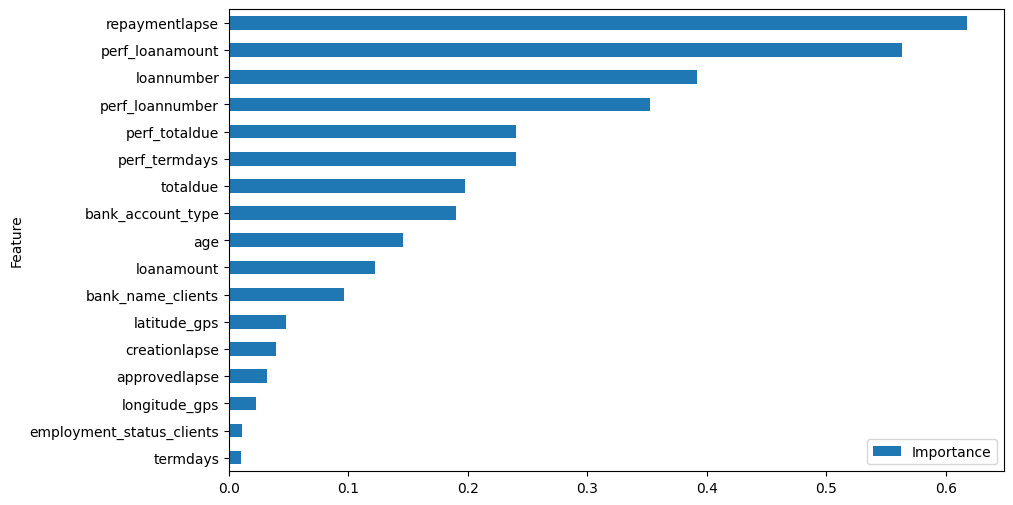

In [771]:
coefficients = logreg.coef_[0]


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [772]:
y_test.value_counts()

good_bad_flag
1.0    696
0.0    178
Name: count, dtype: int64

In [773]:
y_train.value_counts()

good_bad_flag
1.0    2720
0.0     774
Name: count, dtype: int64

In [774]:
#confusion matrix for our model
cm =confusion_matrix(y_test, y_pred_test)

In [775]:
cm

array([[ 15, 163],
       [ 13, 683]])

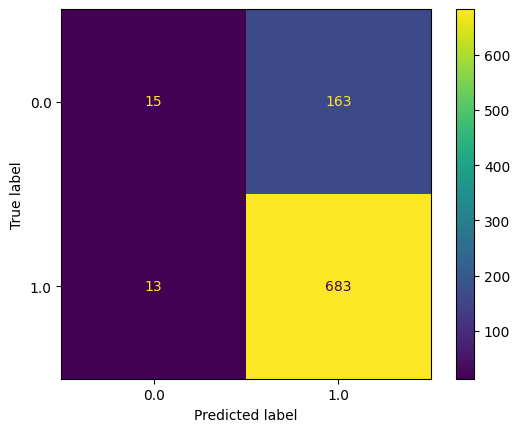

In [776]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [777]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.54      0.08      0.15       178
         1.0       0.81      0.98      0.89       696

    accuracy                           0.80       874
   macro avg       0.67      0.53      0.52       874
weighted avg       0.75      0.80      0.74       874



Let's now apply SMOTE to deal with the imbalanced data

In [778]:
X = loan_data.drop(['good_bad_flag'], axis=1)
y = loan_data['good_bad_flag']

In [779]:
#SMOTE is an oversampling technique that creates new data from existing
#for the minority class in this case, bad loans
#the sampling strategy chosen is all, no change with it being 'minority'
smote_algo = SMOTE(sampling_strategy='all',random_state=0)
smote_data_X, smote_data_Y = smote_algo.fit_resample(X,y)
smote_data_X = pd.DataFrame(data=smote_data_X, columns=X.columns)
smote_data_Y = pd.DataFrame(data=smote_data_Y, columns=['good_bad_flag'])

In [780]:
smote_data = smote_data_X
smote_data['good_bad_flag'] = smote_data_Y['good_bad_flag']

In [781]:
smote_data_Y['good_bad_flag'].value_counts()

good_bad_flag
0.0    3416
1.0    3416
Name: count, dtype: int64

In [782]:
smote_data.drop_duplicates(keep="first", inplace=True) #removing duplicate data if any
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6832 entries, 0 to 6831
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   perf_loannumber            6832 non-null   float64
 1   perf_loanamount            6832 non-null   float64
 2   perf_totaldue              6832 non-null   float64
 3   perf_termdays              6832 non-null   float64
 4   loannumber                 6832 non-null   float64
 5   loanamount                 6832 non-null   float64
 6   totaldue                   6832 non-null   float64
 7   termdays                   6832 non-null   float64
 8   bank_account_type          6832 non-null   float64
 9   longitude_gps              6832 non-null   float64
 10  latitude_gps               6832 non-null   float64
 11  bank_name_clients          6832 non-null   float64
 12  employment_status_clients  6832 non-null   float64
 13  age                        6832 non-null   float

# Logistic Regression

Let's try building our logistic regression model again.

In [783]:
X = smote_data.drop(['good_bad_flag'],axis=1)
y = smote_data['good_bad_flag']

In [784]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)

In [785]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [786]:
X_train.shape, X_test.shape

((5465, 17), (1367, 17))

In [787]:
logreg = LogisticRegression(solver='liblinear', random_state=3)

In [788]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=3, solver='liblinear')

In [789]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([1., 1., 0., ..., 1., 0., 1.])

In [790]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.6305779078273592


In [791]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.6400731930466605


<Axes: ylabel='Feature'>

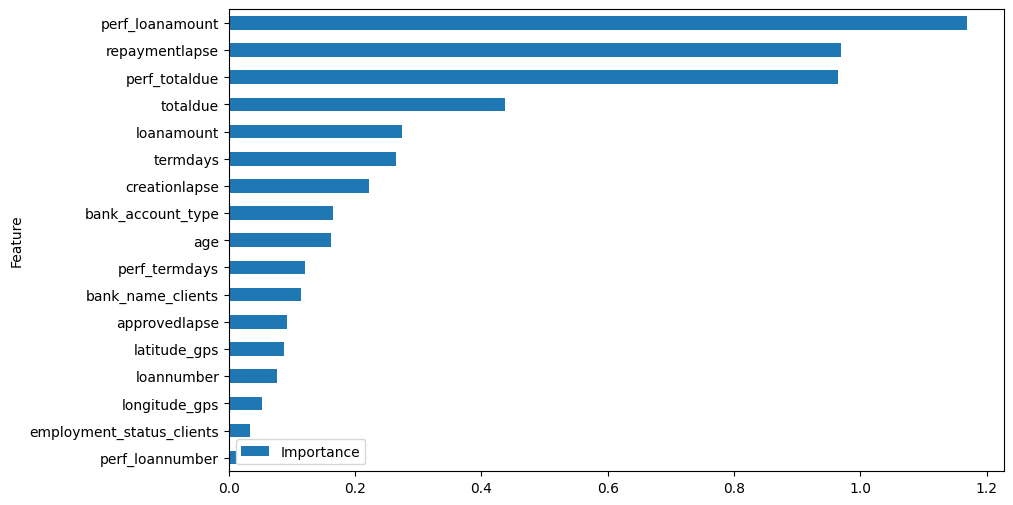

In [792]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [793]:
y_test.value_counts()

good_bad_flag
0.0    697
1.0    670
Name: count, dtype: int64

In [794]:
cm1 =confusion_matrix(y_test, y_pred_test)

In [795]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg.classes_)

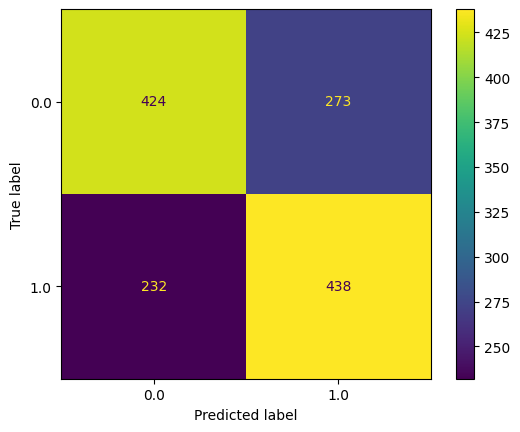

In [796]:
disp.plot()

In [797]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.65      0.61      0.63       697
         1.0       0.62      0.65      0.63       670

    accuracy                           0.63      1367
   macro avg       0.63      0.63      0.63      1367
weighted avg       0.63      0.63      0.63      1367



The random forest results were unsatisfactory so let's ignore them for now and focus on other models.
Side note, feature engineering may improve the performance of this model.

# K-Nearest Neighbour

In [798]:
#we're going to build three models testing out a different number of nearest neighbours to
#see which number is best performing

#model where n_neighbors = 1
knnr = KNeighborsClassifier(n_neighbors = 1, metric='minkowski',p=2)

In [799]:
X_train.shape

(5465, 17)

In [800]:
y_train.shape

(5465,)

In [801]:
knnr.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [802]:
y_pred = knnr.predict(X_test)

In [803]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       697
         1.0       0.86      0.74      0.79       670

    accuracy                           0.81      1367
   macro avg       0.82      0.81      0.81      1367
weighted avg       0.82      0.81      0.81      1367



# Random Forest

In [804]:
# separating the input features, X and the target feature, y that we want to predict
# Xtrain = loan_data.drop(['good_bad_flag'], axis=1)
# ytrain = loan_data['good_bad_flag']

In [805]:
Rf= RandomForestClassifier(n_estimators= 300, random_state= 0)

In [806]:
# X and y are SMOTE data
train_x, val_x, train_y, val_y= train_test_split(X,y,test_size= 0.2, random_state= 42)

Rf= RandomForestClassifier(n_estimators= 300, random_state= 0)
Rf.fit(train_x,train_y)
pred= Rf.predict(val_x)
print("accuracy score:",accuracy_score(pred,val_y))

accuracy score: 0.8507681053401609


Interesting to note, the accuracy of every model drops when I introduce the groupby feature to the train data. Will investigate this further later.

In [807]:
index = test_loan_data.pop('customerid')

In [808]:
# I'll CHECK THIS OUT

# train_x, val_x, train_y, val_y= train_test_split(X,y,test_size= 0.2, random_state= 42)

# Rf= RandomForestClassifier(n_estimators= 300, random_state= 0)
# Rf.fit(train_x,train_y)
# pred= Rf.predict(test_loan_data)
# print("accuracy score:",accuracy_score(pred,test_loan_data))

In [809]:
pred

array([0., 0., 1., ..., 1., 1., 0.])

In [810]:
val_y

1223    1.0
5782    0.0
435     1.0
5755    0.0
2549    1.0
       ... 
1354    1.0
1018    1.0
2249    0.0
977     1.0
809     0.0
Name: good_bad_flag, Length: 1367, dtype: float64

In [811]:
train_x.shape

(5465, 17)

In [812]:
val_x.shape

(1367, 17)

In [813]:
val_x

,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,creationlapse,approvedlapse,repaymentlapse
1223,4.000000,10000.0,13000.0,30.0,2.000000,10000.000000,11500.000000,15.000000,2.000000,3.288399,6.610813,5.000000,1.000000,54.000000,488.833333,487.833333,-134.400000
5782,2.147556,10000.0,13000.0,30.0,1.073778,10000.000000,11500.000000,15.000000,3.000000,4.481972,7.291344,18.000000,1.000000,39.831800,319.005956,318.005956,51.105599
435,6.000000,10000.0,11125.0,15.0,3.000000,12000.000000,14250.000000,21.000000,1.000000,7.072505,8.936134,0.000000,4.000000,42.000000,412.980000,411.980000,105.220000
5755,2.236564,10000.0,13000.0,30.0,1.118282,10000.000000,13000.000000,30.000000,2.763436,4.252407,7.089277,15.161229,1.236564,38.452205,649.907510,648.907510,59.348392
2549,2.000000,10000.0,13000.0,30.0,1.000000,10000.000000,13000.000000,30.000000,2.000000,3.291956,6.466817,10.000000,1.000000,40.000000,242.500000,241.400000,481.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,14.000000,40000.0,44000.0,30.0,7.000000,25384.615385,28446.153846,23.076923,3.000000,4.481972,7.291344,18.000000,1.000000,39.831800,402.253846,401.253846,164.969231
1018,4.000000,10000.0,13000.0,30.0,2.000000,10000.000000,12000.000000,20.000000,2.000000,3.211710,6.918019,10.000000,2.000000,37.000000,615.366667,614.366667,-122.366667
2249,4.000000,10000.0,13000.0,30.0,2.000000,10000.000000,13000.000000,30.000000,2.000000,7.784200,4.976349,13.000000,2.000000,49.000000,723.300000,722.300000,14.166667
977,3.000000,10000.0,13000.0,30.0,1.500000,10000.000000,13000.000000,30.000000,3.000000,4.481972,7.291344,18.000000,1.000000,39.831800,684.000000,683.000000,48.800000


In [814]:
train_y.shape

(5465,)

In [815]:
val_y.shape

(1367,)

In [816]:
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       670
         1.0       0.83      0.89      0.86       697

    accuracy                           0.85      1367
   macro avg       0.85      0.85      0.85      1367
weighted avg       0.85      0.85      0.85      1367



<Axes: >

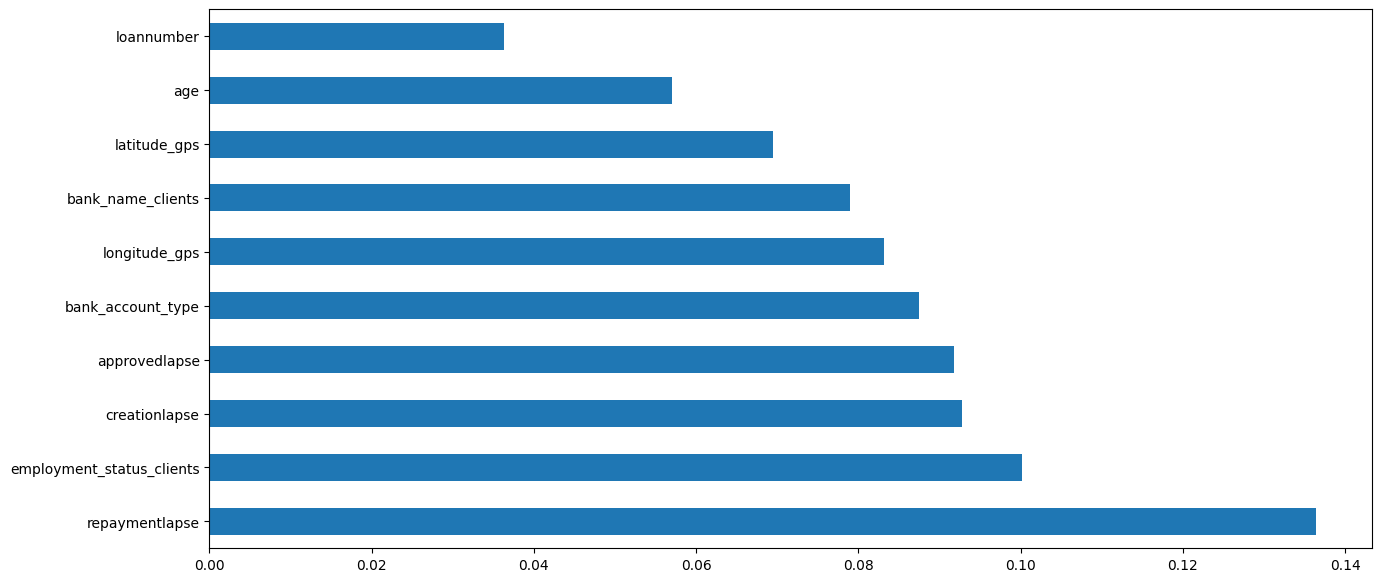

In [817]:
#feature importance for Random ForestClassifier

%matplotlib inline
plt.figure(figsize=(15,7))
feat_importances = pd.Series(Rf.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [818]:
cm2 = confusion_matrix(val_y, pred)

In [819]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=logreg.classes_)

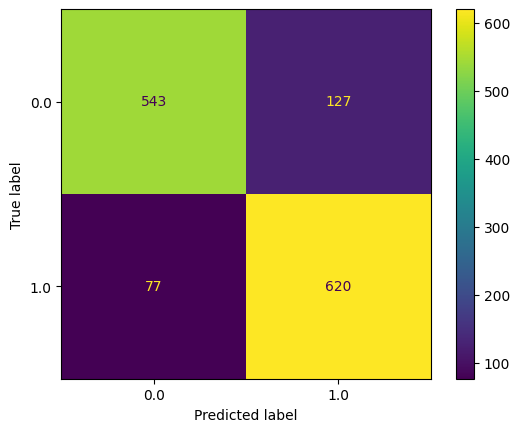

In [820]:
disp.plot()

In [821]:
# index = test_loan_data.pop('customerid')

In [822]:
test_that = Rf.predict(test_loan_data)

In [823]:
submission= pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/SampleSubmission.csv')
submission

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1
...,...,...
1445,8a858fff5a36fe68015a3744f0021e89,1
1446,8aaae7a74400b28201441c8b62514150,1
1447,8aab10f748cf78ff0148d11fac1447a6,1
1448,8aab160f499477da014999ba2f0f578b,1


In [824]:
test_hub = pd.DataFrame({'customerid':index, 'Good_Bad_flag': test_that})

test_hub.to_csv('OAU3.csv', index= False)

In [825]:
test_hub

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,0.0
1,8a3735d5518aba7301518ac34413010d,0.0
2,8a76e7d443e6e97c0143ed099d102b1d,0.0
3,8a818823525dceef01525deda2480384,0.0
4,8a818926522ea5ef01523aff15c37482,0.0
...,...,...
1445,8a858fff5a36fe68015a3744f0021e89,0.0
1446,8aaae7a74400b28201441c8b62514150,0.0
1447,8aab10f748cf78ff0148d11fac1447a6,0.0
1448,8aab160f499477da014999ba2f0f578b,0.0


In [826]:
# trueset = pd.merge(submission, test_hub, on='customerid')
# trueset